In [5]:
import matplotlib.pyplot as plt
import numpy as np


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Theory

In [3]:
def plot_rdk_hist(fraction_subset, p_subset, p_background, num_dots, num_directions):
    p = {"s": p_subset, "b": p_background}
    num_group = dict(s=int(fraction_subset * num_dots))
    num_group["b"] = num_dots - num_group["s"]
    mu = {}
    sigma2 = {}
    mu_dir = {}
    sigma2_dir = {}
    titles = {"s": "subset", "b": "background", "t": "total"}
    dirn = {"s": -2, "b": num_directions // 2}
    for k in "sb":
        for d in "ci":
            if d == "c":
                p_cur = p[k]
            else:
                p_cur = 1 / num_directions
            mu[k, d] = num_group[k] * p_cur
            sigma2[k, d] = num_group[k] * p_cur * (1 - p_cur)
        for param_dir, param_dict in [(mu_dir, mu), (sigma2_dir, sigma2)]:
            param_dir[k] = np.ones(num_directions + 1) * param_dict[k, "i"]
            param_dir[k][dirn[k]] = param_dict[k, "c"]
            param_dir[k][-1] = param_dir[k][0]
    mu_dir["t"] = fraction_subset * mu_dir["s"] + (1 - fraction_subset) * mu_dir["b"]
    sigma2_dir["t"] = (
        fraction_subset * sigma2_dir["s"] + (1 - fraction_subset) * sigma2_dir["b"]
    )
    theta = np.linspace(0, 2 * np.pi, num_directions + 1)
    plt.figure(figsize=(16, 8))
    for i, k in enumerate("sbt"):
        normfac = 1 / np.amin(mu_dir[k])
        plt.subplot(1, 3, i + 1, polar=True)
        plt.polar(theta, normfac * mu_dir[k], color="C" + str(i))
        s = np.sqrt(sigma2_dir[k]) * 1.96
        plt.fill_between(
            theta,
            normfac * (mu_dir[k] - s),
            normfac * (mu_dir[k] + s),
            color="C" + str(i),
            alpha=0.2,
        )
        plt.title(titles[k] + "\n")
    plt.tight_layout()


In [3]:
import ipywidgets as widgets


@widgets.interact(
    fraction_subset=widgets.FloatSlider(0.1, min=0.0, max=1.0, step=0.1),
    p_subset=widgets.FloatSlider(0.9, min=0.0, max=1.0, step=0.1),
    p_background=widgets.FloatSlider(0.2, min=0.0, max=1.0, step=0.1),
    num_dots=widgets.IntSlider(500, min=10, max=1000, step=10),
    num_directions=widgets.IntSlider(180, min=10, max=360, step=10),
)
def plot_interactive(fraction_subset, p_subset, p_background, num_dots, num_directions):
    plot_rdk_hist(fraction_subset, p_subset, p_background, num_dots, num_directions)

interactive(children=(FloatSlider(value=0.1, description='fraction_subset', max=1.0), FloatSlider(value=0.9, d…

## From RDK actual sampling

In [3]:
from rdktools.rdk_params import Params, get_random_params
from rdktools.rdk_stimuli import RDK
from rdktools.rdk_experiment import other_angle, Experiment


pygame 2.1.2 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [136]:
import ipywidgets as widgets
from IPython.display import display, HTML


def get_hist(theta, nbins=50):

    radii, thetas = [list(d) for d in np.histogram(theta, bins=nbins)[:2]]

    thetas = [(r1 + r2) / 2 for r1, r2 in zip(thetas[:-1], thetas[1:])]
    thetas.append(thetas[0]), radii.append(radii[0])

    thetas = np.deg2rad(thetas)
    radii = np.array(radii)  # / np.max(radii)

    return thetas, radii


def plot_rdk(rdk, p_subset):

    thetas = [[] for _ in range(3)]


    rdk.sample_dots(rdk.max_radius, rdk.ndots)

    for _ in range(int(1000)):
        rdk.update()
        if rdk.rand < p_subset:
            thetas[0].append(rdk.dot_motiondirs)
        else:
            thetas[1].append(rdk.dot_motiondirs)

        thetas[2].append(rdk.dot_motiondirs)

    thetas = [np.concatenate(t) for t in thetas]

    fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "polar"}, figsize=(10, 5))

    axs[0].plot(*get_hist(thetas[0]), label="dots")
    axs[0].set_title("Subset Moving")
    axs[1].plot(*get_hist(thetas[1]), label="dots")
    axs[1].set_title("Subset Random")
    axs[2].plot(*get_hist(thetas[2]), label="dots")
    axs[2].set_title("Average")

    [ax.get_yaxis().set_visible(False) for ax in axs]
    # [[ax.vlines([a], [0], [1], color=c, label=l, linestyle='--') for a, c, l in zip(angles, ['b', 'r'], ['global', 'subset'])] for ax in axs]
    # [ax.legend() for ax in axs]


def plot_rdk_motions_and_launch(
    fraction_subset,
    p_subset,
    temp_coherent,
    p_background,
    diffusion,
    diffuse_subset,
    name,
    comod,
    n_angles,
):

    params = Params(
        N_TRIALS_PER_BATCH=10,
        N_BATCH=1,
        TEMPORALLY_COHERENT=True,
    )

    # angles = (angle_s, angle_b)

    params.SUBSET_RATIO = fraction_subset
    params.TEMPORALLY_COHERENT = temp_coherent
    
    params.DIFFUSION_SCALE = diffusion
    params.DIFFUSE_SUBSET = diffuse_subset
    params.NAME = name
    params.COMOD = comod
    params.N_ANGLES = n_angles

    if not comod : 
        angles = [0, 90]
        params.DOT_COHERENCE = [p_background, p_subset]
    else : 
        angles = np.linspace(0, 360, n_angles, endpoint=False)
        params.DOT_COHERENCE = [p_subset for _ in range(n_angles)]

    rdk = RDK(None, params)
    rdk.new_sample(angles)
    angles = np.deg2rad(angles)

    plot_rdk(rdk, p_subset)

    print(np.unique(rdk.motiondirs))

    return params

style = {'description_width' : 'initial'}

controls = {
    "fraction_subset": widgets.FloatSlider(0.1, min=0.0, max=1.0, step=0.05, style=style),
    "p_subset": widgets.FloatSlider(0.9, min=0.0, max=1.0, step=0.05, style=style),
    "temp_coherent": widgets.ToggleButton(value=True, description="Temporally Coherent ?", style=style),
    "p_background": widgets.FloatSlider(0.2, min=0.0, max=1.0, step=0.1, style=style),
    #"num_batches": widgets.IntSlider(10, min=1, max=30, step=1, style=style),
    #"num_examples_per_batch": widgets.IntSlider(3, min=1, max=10, step=1, style=style),
    # angle_s = widgets.IntSlider(90, min=0, max=360, step=10),
    # angle_b = widgets.IntSlider(0, min=0, max=360, step=10),
    "diffusion": widgets.IntSlider(0, min=0, max=360, step=1, style=style),
    "diffuse_subset": widgets.ToggleButton(value=False, description="Diffuse Subset ?", style=style),
    "comod" : widgets.ToggleButton(value=False, description="COMOD ?", style=style),
    'n_angles' : widgets.IntSlider(4, min=2, max=20, step=1, style=style),
    "name": widgets.Text(
        value="gabriel", placeholder="type your name", description="Name", style=style
    ),
}

In [137]:
interactive_exp = widgets.interactive(plot_rdk_motions_and_launch, **controls, layout={'width': '5000px'})

display(interactive_exp)

exp = Experiment(
    interactive_exp.result, None, save_data=False, save_gif=False, randomize=False
)

button = widgets.Button(description="Lauch Experiment!")
output = widgets.Output()

display(button, output, width='10000')

def on_button_clicked(button):
    exp.__init__(
        interactive_exp.result, None, save_data=False, save_gif=False, randomize=False
    )
    with output:
        exp.run()

    return exp

button.on_click(on_button_clicked)

interactive(children=(FloatSlider(value=0.1, description='fraction_subset', max=1.0, step=0.05, style=SliderSt…

Button(description='Lauch Experiment!', style=ButtonStyle())

Output()

In [179]:
from scipy.optimize import minimize, NonlinearConstraint
def get_n_colors(n_angles) : 
    
    p = [1, -3, 2, 0]
    f_to_min = lambda x : np.polyval(p, x) - n_angles
    x_min = minimize(f_to_min, 3, constraints= NonlinearConstraint(f_to_min, 0, np.inf) )
    return np.ceil(x_min.x).astype(int)[0]

In [180]:
n_angles = 8



[array([  0.,  85., 170., 255.]),
 array([  0.,  85., 170., 255.]),
 array([  0.,  85., 170., 255.])]

In [249]:
def get_random_colors(n_angles) : 
    n_colors = get_n_colors(n_angles)
    colors = np.linspace(0, 255, n_colors).astype(int)
    col_idxs = np.random.choice(np.arange(n_colors), size=3, replace=False)
    col_idxs = [(col_idxs + i)%n_colors for i in range(n_angles)]
    return [colors[idx] for i, idx in enumerate(col_idxs)]


In [255]:
colors = get_random_colors(20)
np.unique(np.stack(colors), axis=0)

array([[  0, 255, 170],
       [ 85,   0, 255],
       [170,  85,   0],
       [255, 170,  85]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


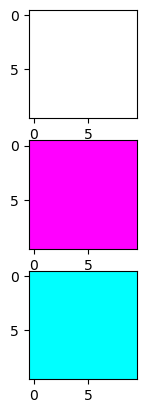

In [251]:
fig, axs = plt.subplots(3, 1)
for ax, c in zip(axs, colors) : 
    ax.imshow(np.ones((10, 10, 3)) * c)

In [139]:
exp.results_pd.describe()[["absolute_error_global", "absolute_error_subset"]]

AttributeError: 'Experiment' object has no attribute 'results_pd'

In [10]:
exp.params


Params(NAME='gabriel', WINDOW_WIDTH=300, WINDOW_HEIGHT=300, APERTURE_RADIUS=150, WINDOW_NAME='Random Dot Kinematogram', TICK_RATE=60, TIME_FIX=20, TIME_ISI=30, TIME_RDK=300, TIME_ITI=10, N_DOTS=282, DOT_SIZE=3, DOT_SPEED=4, DOT_ANGLES=None, N_TRIALS_PER_BATCH=3, N_BATCH=10, DOT_REPETITIONS=1, DOT_COHERENCE=[0.3, 0.9], SUBSET_RATIO=0.1, DIFFUSED_DIRECTION=False, APERTURE_WIDTH=4, FIX_SIZE=(5, 5), FIX_WIDTH=2, COL_BLACK=(0, 0, 0), COL_WHITE=(255, 255, 255), COL_BLUE=(30, 144, 255), COL_RED=(178, 34, 34), DOT_COLOR=(255, 255, 255), WINDOW_COLOUR=(0, 0, 0), APERTURE_COLOR=(255, 255, 255), FIX_COLOR=(255, 255, 255))

## Comod Task

In [96]:
from rdktools.rdk_stimuli import RDK

def plot_comod_rdk(n_angles) : 
        
    coherences = [1/n_angles for _ in range(n_angles)]

    angles = np.linspace(0, 360, n_angles, endpoint=False)
    p_subset = [1/n_angles for _ in range(n_angles)]
    params = Params(DOT_COHERENCE=coherences, N_DOTS=500)

    rdk = RDK(None, params, angles)

    plot_rdk(rdk, coherences[0])
    
controls = {
    "n_angles": widgets.IntSlider(4, min=2, max=20, step=1, style=style) }

interactive_plot = widgets.interactive(plot_comod_rdk, **controls, layout={'width': '5000px'})
display(interactive_plot)

interactive(children=(IntSlider(value=4, description='n_angles', max=20, min=2, style=SliderStyle(description_…

In [98]:
spaced_out = np.linspace(0, 360, 4, endpoint=False)

In [99]:
angles = np.random.randint(0, 360, 10)

In [106]:
v_sum = np.vectorize(lambda d : spaced_out+d, signature='(n),(d)->(n, d)')
v_sum(angles)

ValueError: setting an array element with a sequence.

(10, 4)

In [86]:
rdk.dots

<Group(500 sprites)>

In [81]:
np.random.randint(0, 4)

1

In [72]:
angles

array([  0.,  90., 180., 270.])